Look back if not sure (about the exp setting): hyp.yaml and opt.yaml

sound results:
- 191. The baseline. fine tune 5 and fl (1.5/0.75). 450 epoch (NOT THE BASE)
- 192. The pretrain baseline 150, then cyolo 300. fine tune 5 and fl (1.5/0.75). 
- 

Plotting for 191 

In [81]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import yaml
from utils.plots import plot_images
from utils.datasets import create_dataloader
from train_with_bcc import get_file_volunteers_dict
from train_with_bcc import VOL_ID_MAP as vol_id_map

from matplotlib import pyplot as plt
from IPython.display import Image
from itertools import product
import matplotlib
%matplotlib inline

import numpy as np
import torch

from shutil import copyfile, rmtree
from pathlib import Path
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Populating the interactive namespace from numpy and matplotlib


C:\Users\ry00042\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['exp', 'product', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [82]:
rel_path = os.path.join(os.curdir, 'runs', 'train')

In [83]:
def read_exp_results(exp_no, exp_prefix='exp'):
    exp_prefix = 'exp'
    exp_name = f'{exp_prefix}{exp_no}'
    exp_path = os.path.join(rel_path, exp_name)
    res_file_name = os.path.join(exp_path, 'results.csv')
    results_df = pd.read_csv(res_file_name)
    pred = json.load(open(os.path.join(exp_path, '_predictions.json'))) #todo
    hyp = yaml.safe_load(open(os.path.join(exp_path, 'hyp.yaml'))) #todo
    opt = yaml.safe_load(open(os.path.join(exp_path, 'opt.yaml'))) #todo
    return {'results': results_df, 'hyp': hyp, 'opt': opt, 'pred': pred}

def get_im_vol_list(target_volunteers, num_images):
    im_vol_list = []
    for i in range(num_images):
        x = target_volunteers[target_volunteers[:,0] == i, -1].int().detach().numpy()
        num_boxes = x.shape[0]
        vol_per_im = []
        for j in range(num_boxes):
            vol_per_im.append(x[j])
        im_vol_list.append(vol_per_im)
    return im_vol_list

In [84]:
img_info_map = {'imgs': None,
                'volunteer_labels': None,
                'expert_labels': None,
                'yolo_labels': None,
                'cyolo_labels': None}

In [85]:
yolo_exp_id = 191
yolo_results = read_exp_results(yolo_exp_id)
yolo_results, yolo_hyp, yolo_opt, yolo_pred = [yolo_results[x] for x in ['results', 'hyp', 'opt', 'pred']]

cyolo_exp_id = 192
cyolo_results = read_exp_results(cyolo_exp_id)
cyolo_results, cyolo_hyp, cyolo_opt, cyolo_pred = [cyolo_results[x] for x in ['results', 'hyp', 'opt', 'pred']]

In [86]:
data_dict = yaml.safe_load(open(cyolo_opt['data']))
val_path = os.path.join(data_dict['path'], data_dict['val'])
imgsz = cyolo_opt['imgsz']
batch_size = 20

In [87]:
volunteers_loader, volunteers_dataset = create_dataloader(val_path, imgsz, batch_size, 32, hyp=hyp, augment=False)
file_volunteers_dict = get_file_volunteers_dict(data_dict, mode='val', vol_id_map = vol_id_map)

temp_data_name = 'temp'
data_home, data_name = data_dict['path'].split('/')
user = 'Jonathan'

temp_dir = os.path.join(data_home, temp_data_name)
temp_la_dir = os.path.join(temp_dir, 'labels')
temp_im_dir = os.path.join(temp_dir, 'images')
Path(temp_la_dir).mkdir(parents=True, exist_ok=True)
Path(temp_im_dir).mkdir(parents=True, exist_ok=True)

for f in volunteers_dataset.label_files:
    la_name = f.split(os.sep)[-1]
    im_name = la_name.split('.')[0]+'.jpg'
    la_path = os.path.join(data_home, 'master', 'labels', user, la_name)
    im_path = os.path.join(data_home, 'master', 'images', im_name)
    temp_la_path = os.path.join(temp_la_dir, la_name)
    temp_im_path = os.path.join(temp_im_dir, im_name)
    copyfile(la_path, temp_la_path)
    copyfile(im_path, temp_im_path)

expert_loader, expert_dataset = create_dataloader(temp_im_dir, imgsz, batch_size, 32, hyp=hyp, augment=False)

for i, (vol, exp) in enumerate(zip(volunteers_loader, expert_loader)):
    imgs, vol_targets, _, _ = vol
    _, exp_targets, _, _ = exp
    img_info_map['imgs'] = imgs
    img_info_map['volunteer_labels'] = vol_targets
    img_info_map['expert_labels'] = exp_targets
    break

Scanning 'datasets\bcc-tvt\labels\val.cache' images and labels... 20 found, 0 missing, 3 empty, 0 corrupted: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]
Scanning 'datasets\temp\labels' images and labels...:   0%|                                                                                                                                                    | 0/20 [00:00<?, ?it/s]
Scanning 'datasets\temp\labels' images and labels...1 found, 0 missing, 0 empty, 0 corrupted:   5%|█████                                                                                               | 1/20 [00:04<01:27,  4.63s/it]
Scanning 'datasets\temp\labels' images and labels...20 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.13it/s]
Scanning 'datasets\bcc-tvt\labels\val.cache' images and labels... 20 found, 

In [88]:
rmtree(temp_dir)

In [89]:
im_id_map = {x.split(os.sep)[-1].split('.')[0]: i for i, x in enumerate(volunteers_dataset.label_files)}

In [90]:
df_pred = pd.DataFrame(yolo_pred)
conf_thres = 0.25
df_pred = df_pred[df_pred['score']>conf_thres]
pred_targets = torch.tensor(list(df_pred.apply(lambda x: [im_id_map[x['image_id']]] +[x['category_id']] +x['bbox'] + [x['score']], axis=1)))
img_info_map['yolo_labels'] = pred_targets

df_pred = pd.DataFrame(cyolo_pred)
conf_thres = 0.25
df_pred = df_pred[df_pred['score']>conf_thres]
pred_targets = torch.tensor(list(df_pred.apply(lambda x: [im_id_map[x['image_id']]] +[x['category_id']] +x['bbox'] + [x['score']], axis=1)))
img_info_map['cyolo_labels'] = pred_targets

## Volunteer labels

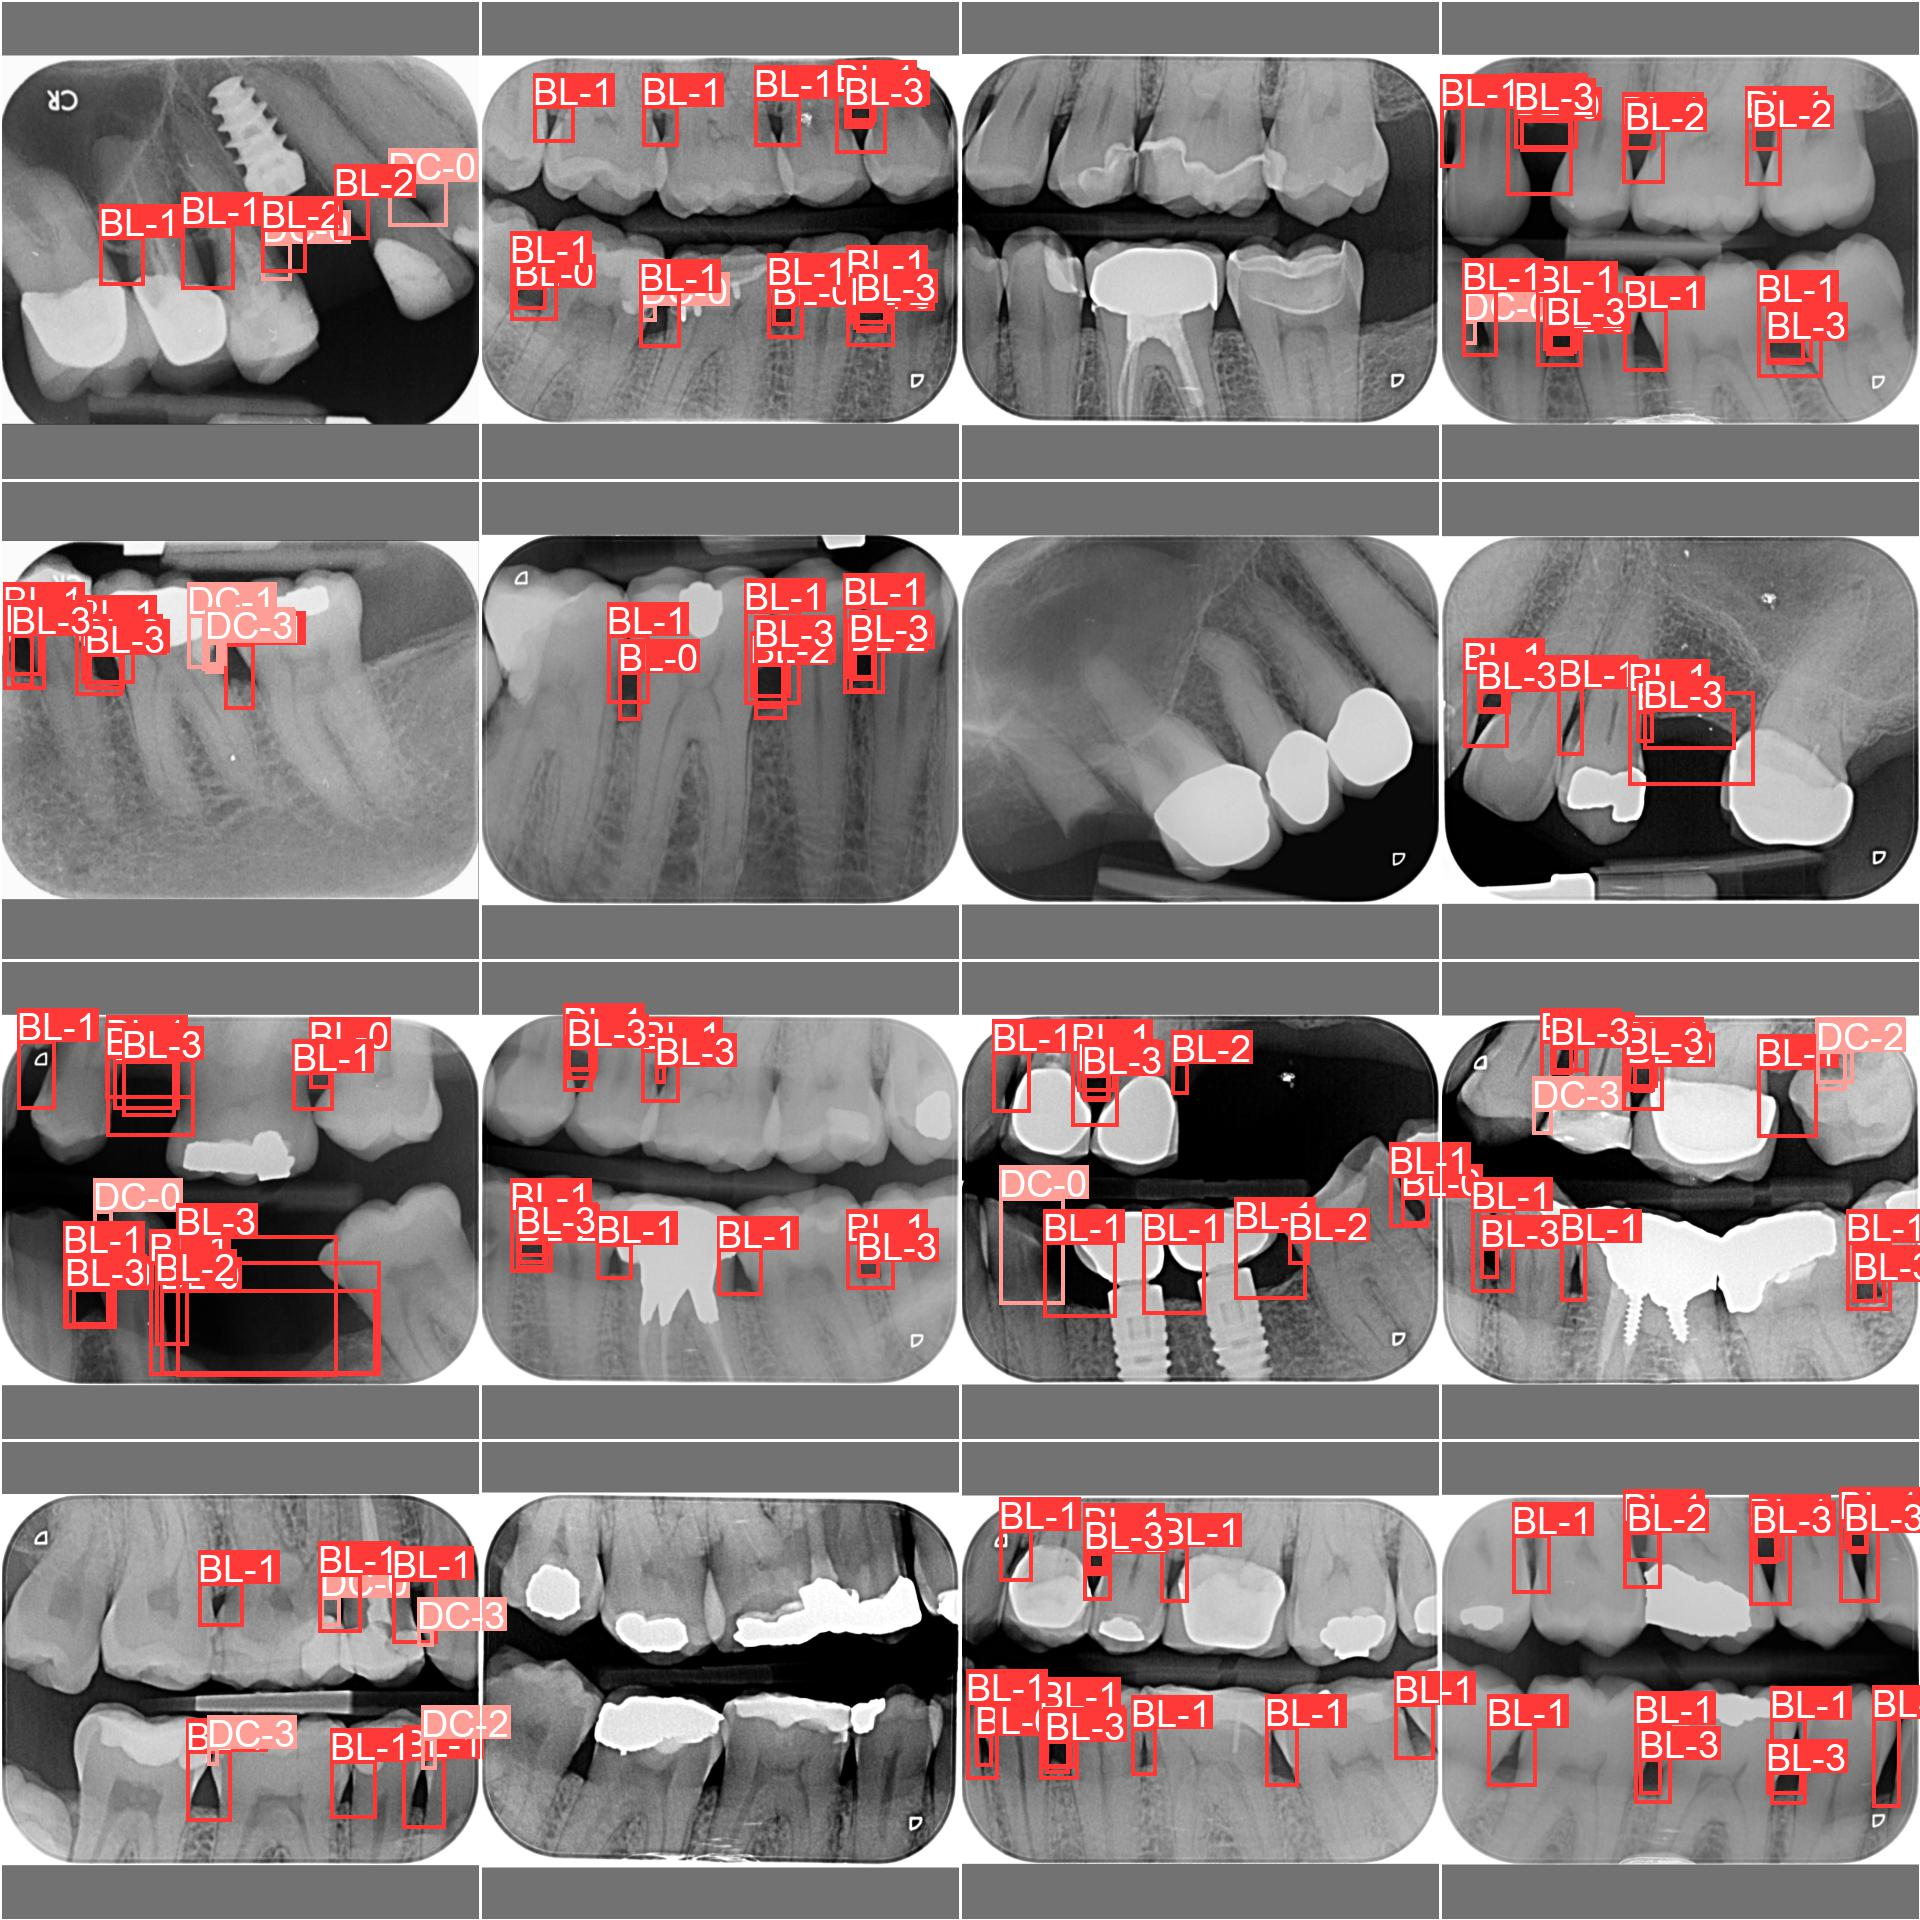

In [26]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

batch_filenames = [volunteers_dataset.label_files[x].split(os.sep)[-1] for x in np.where(volunteers_dataset.batch==i)[0]]
batch_volunteers_list = [file_volunteers_dict[fn] for fn in batch_filenames]
batch_volunteers = torch.cat(batch_volunteers_list)
target_volunteers = torch.cat([img_info_map['volunteer_labels'], batch_volunteers.unsqueeze(-1)], axis=1)
im_vol_list = get_im_vol_list(target_volunteers, imgs.shape[0])
plot_images(imgs, img_info_map['volunteer_labels'], names = ['BL', 'DC'], volunteers = im_vol_list)
pil_img = Image(filename='images.jpg')
display(pil_img)

## Expert labels (Jonathan)

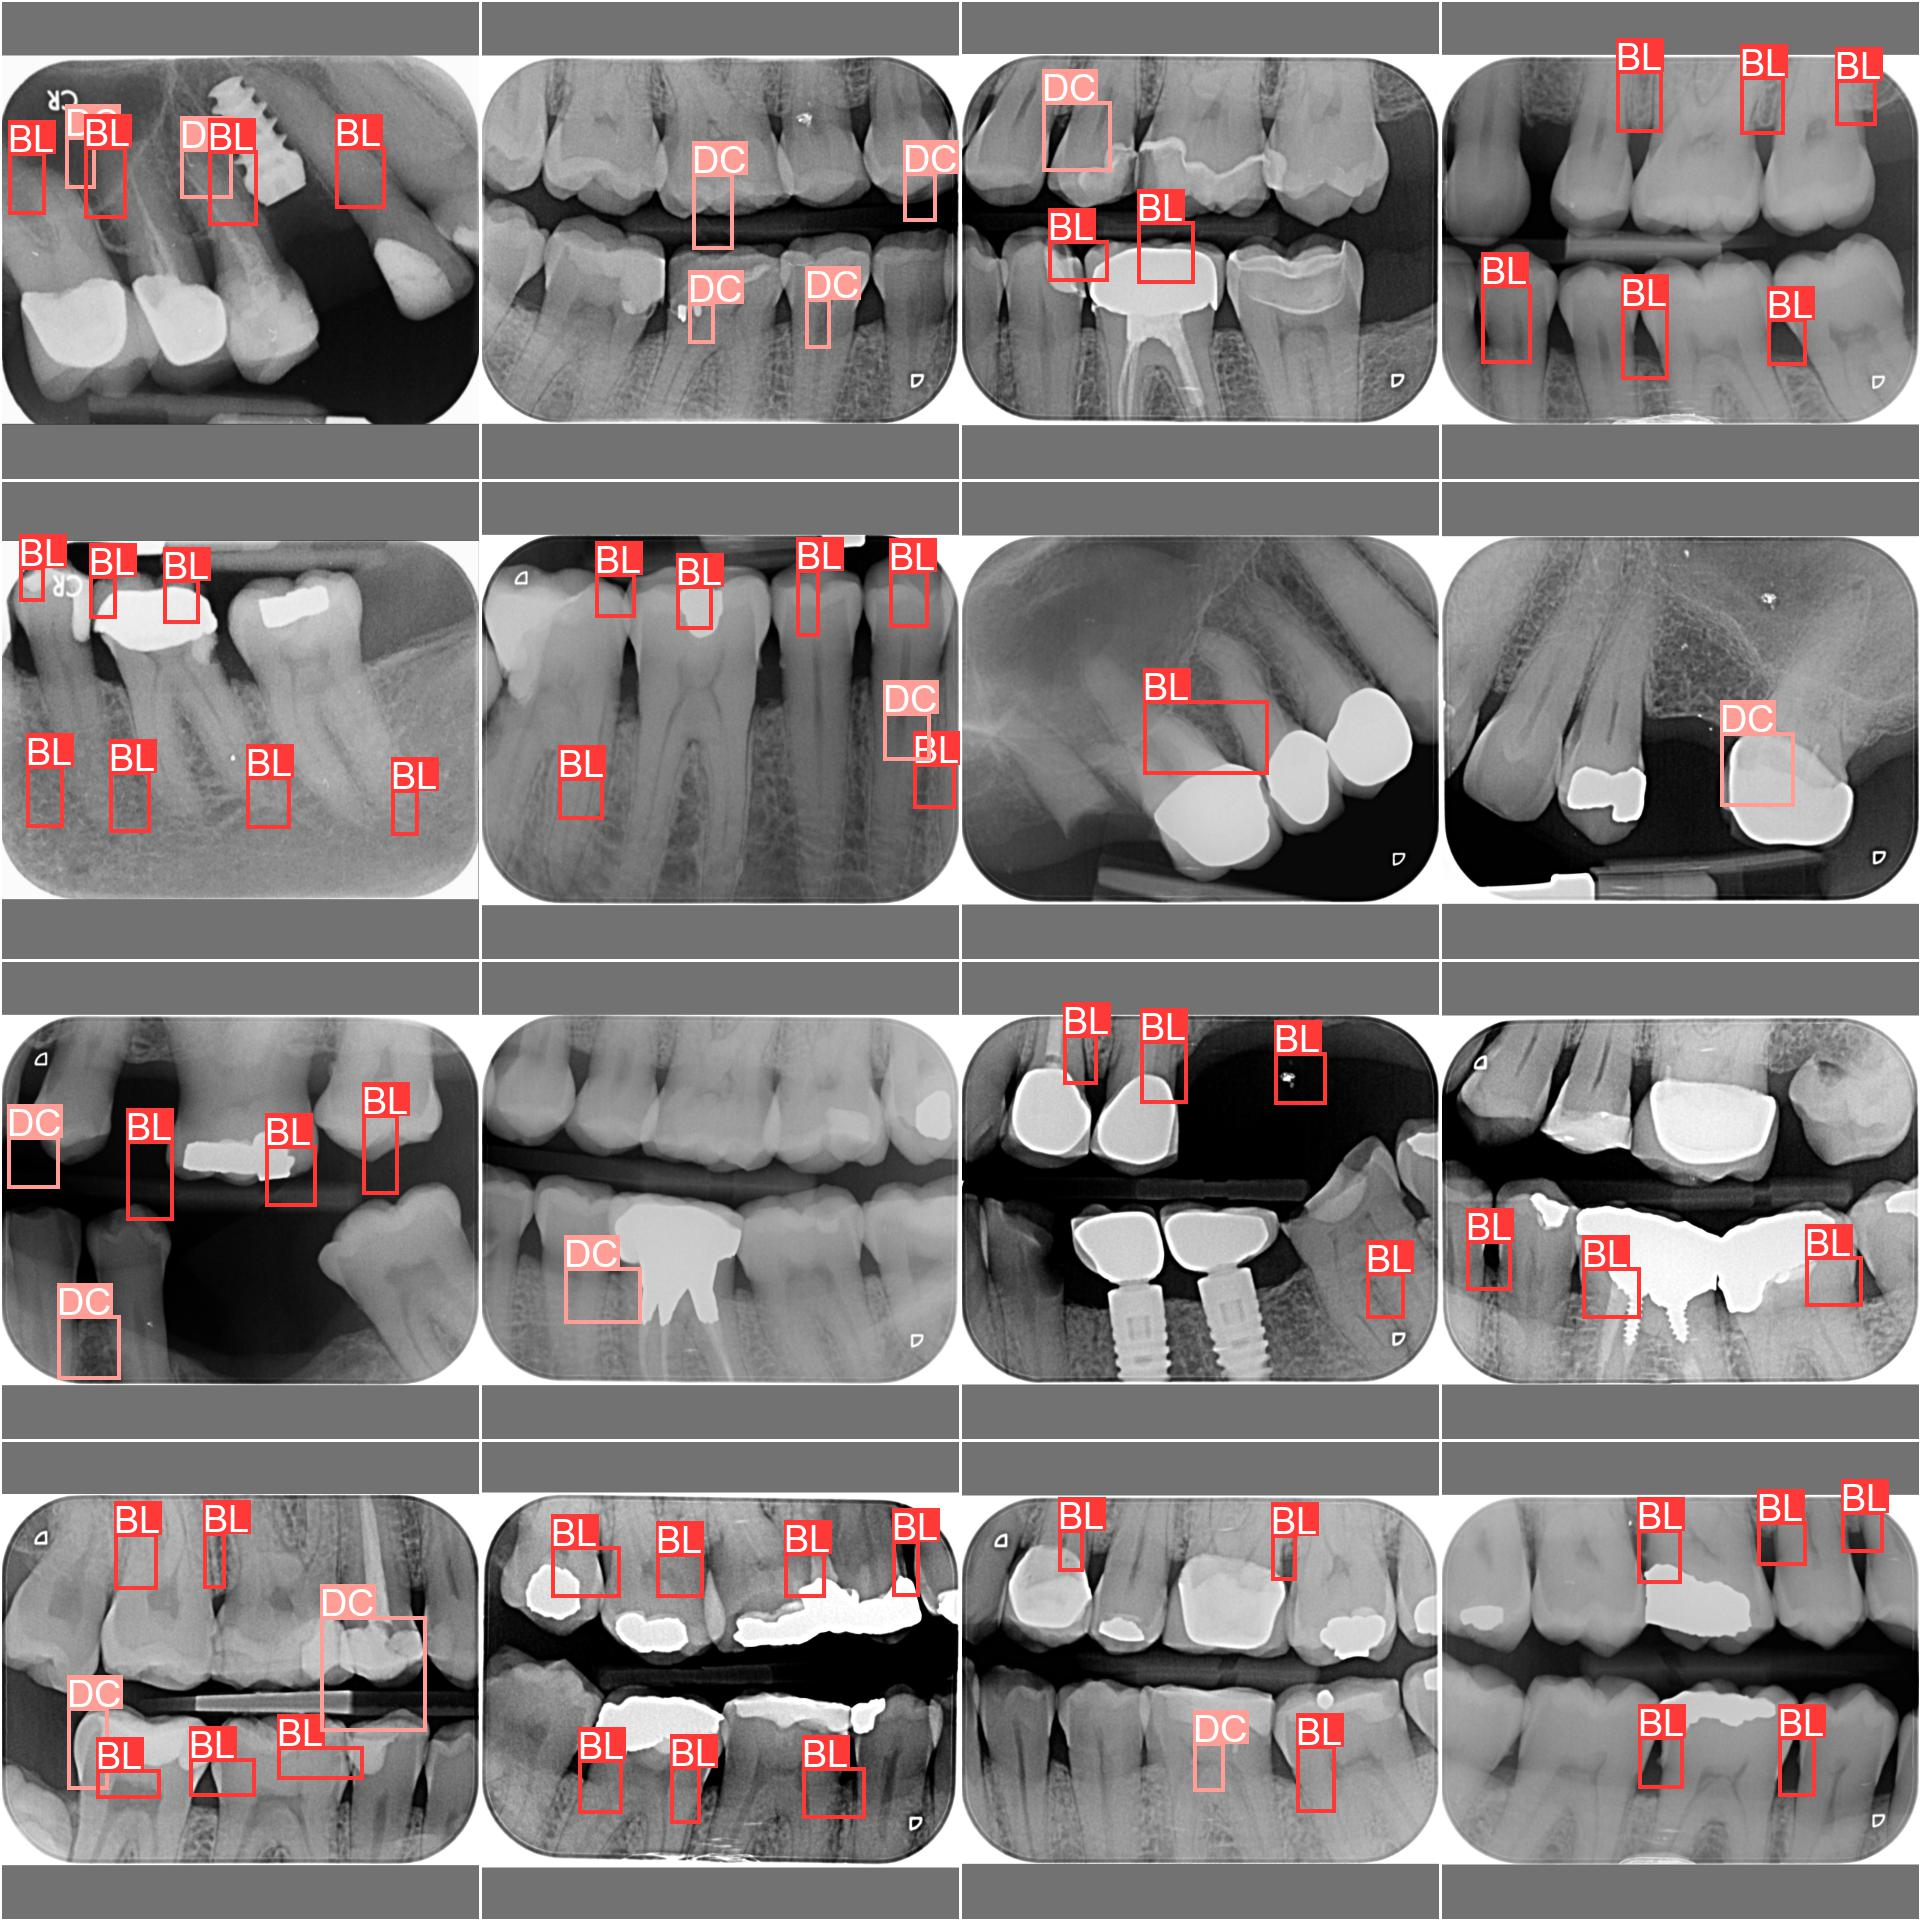

In [27]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

plot_images(imgs, img_info_map['expert_labels'], names = ['BL', 'DC'])
pil_img = Image(filename='images.jpg')
display(pil_img)

## YOLO labels (TODO: fix the boxes -- normalize)

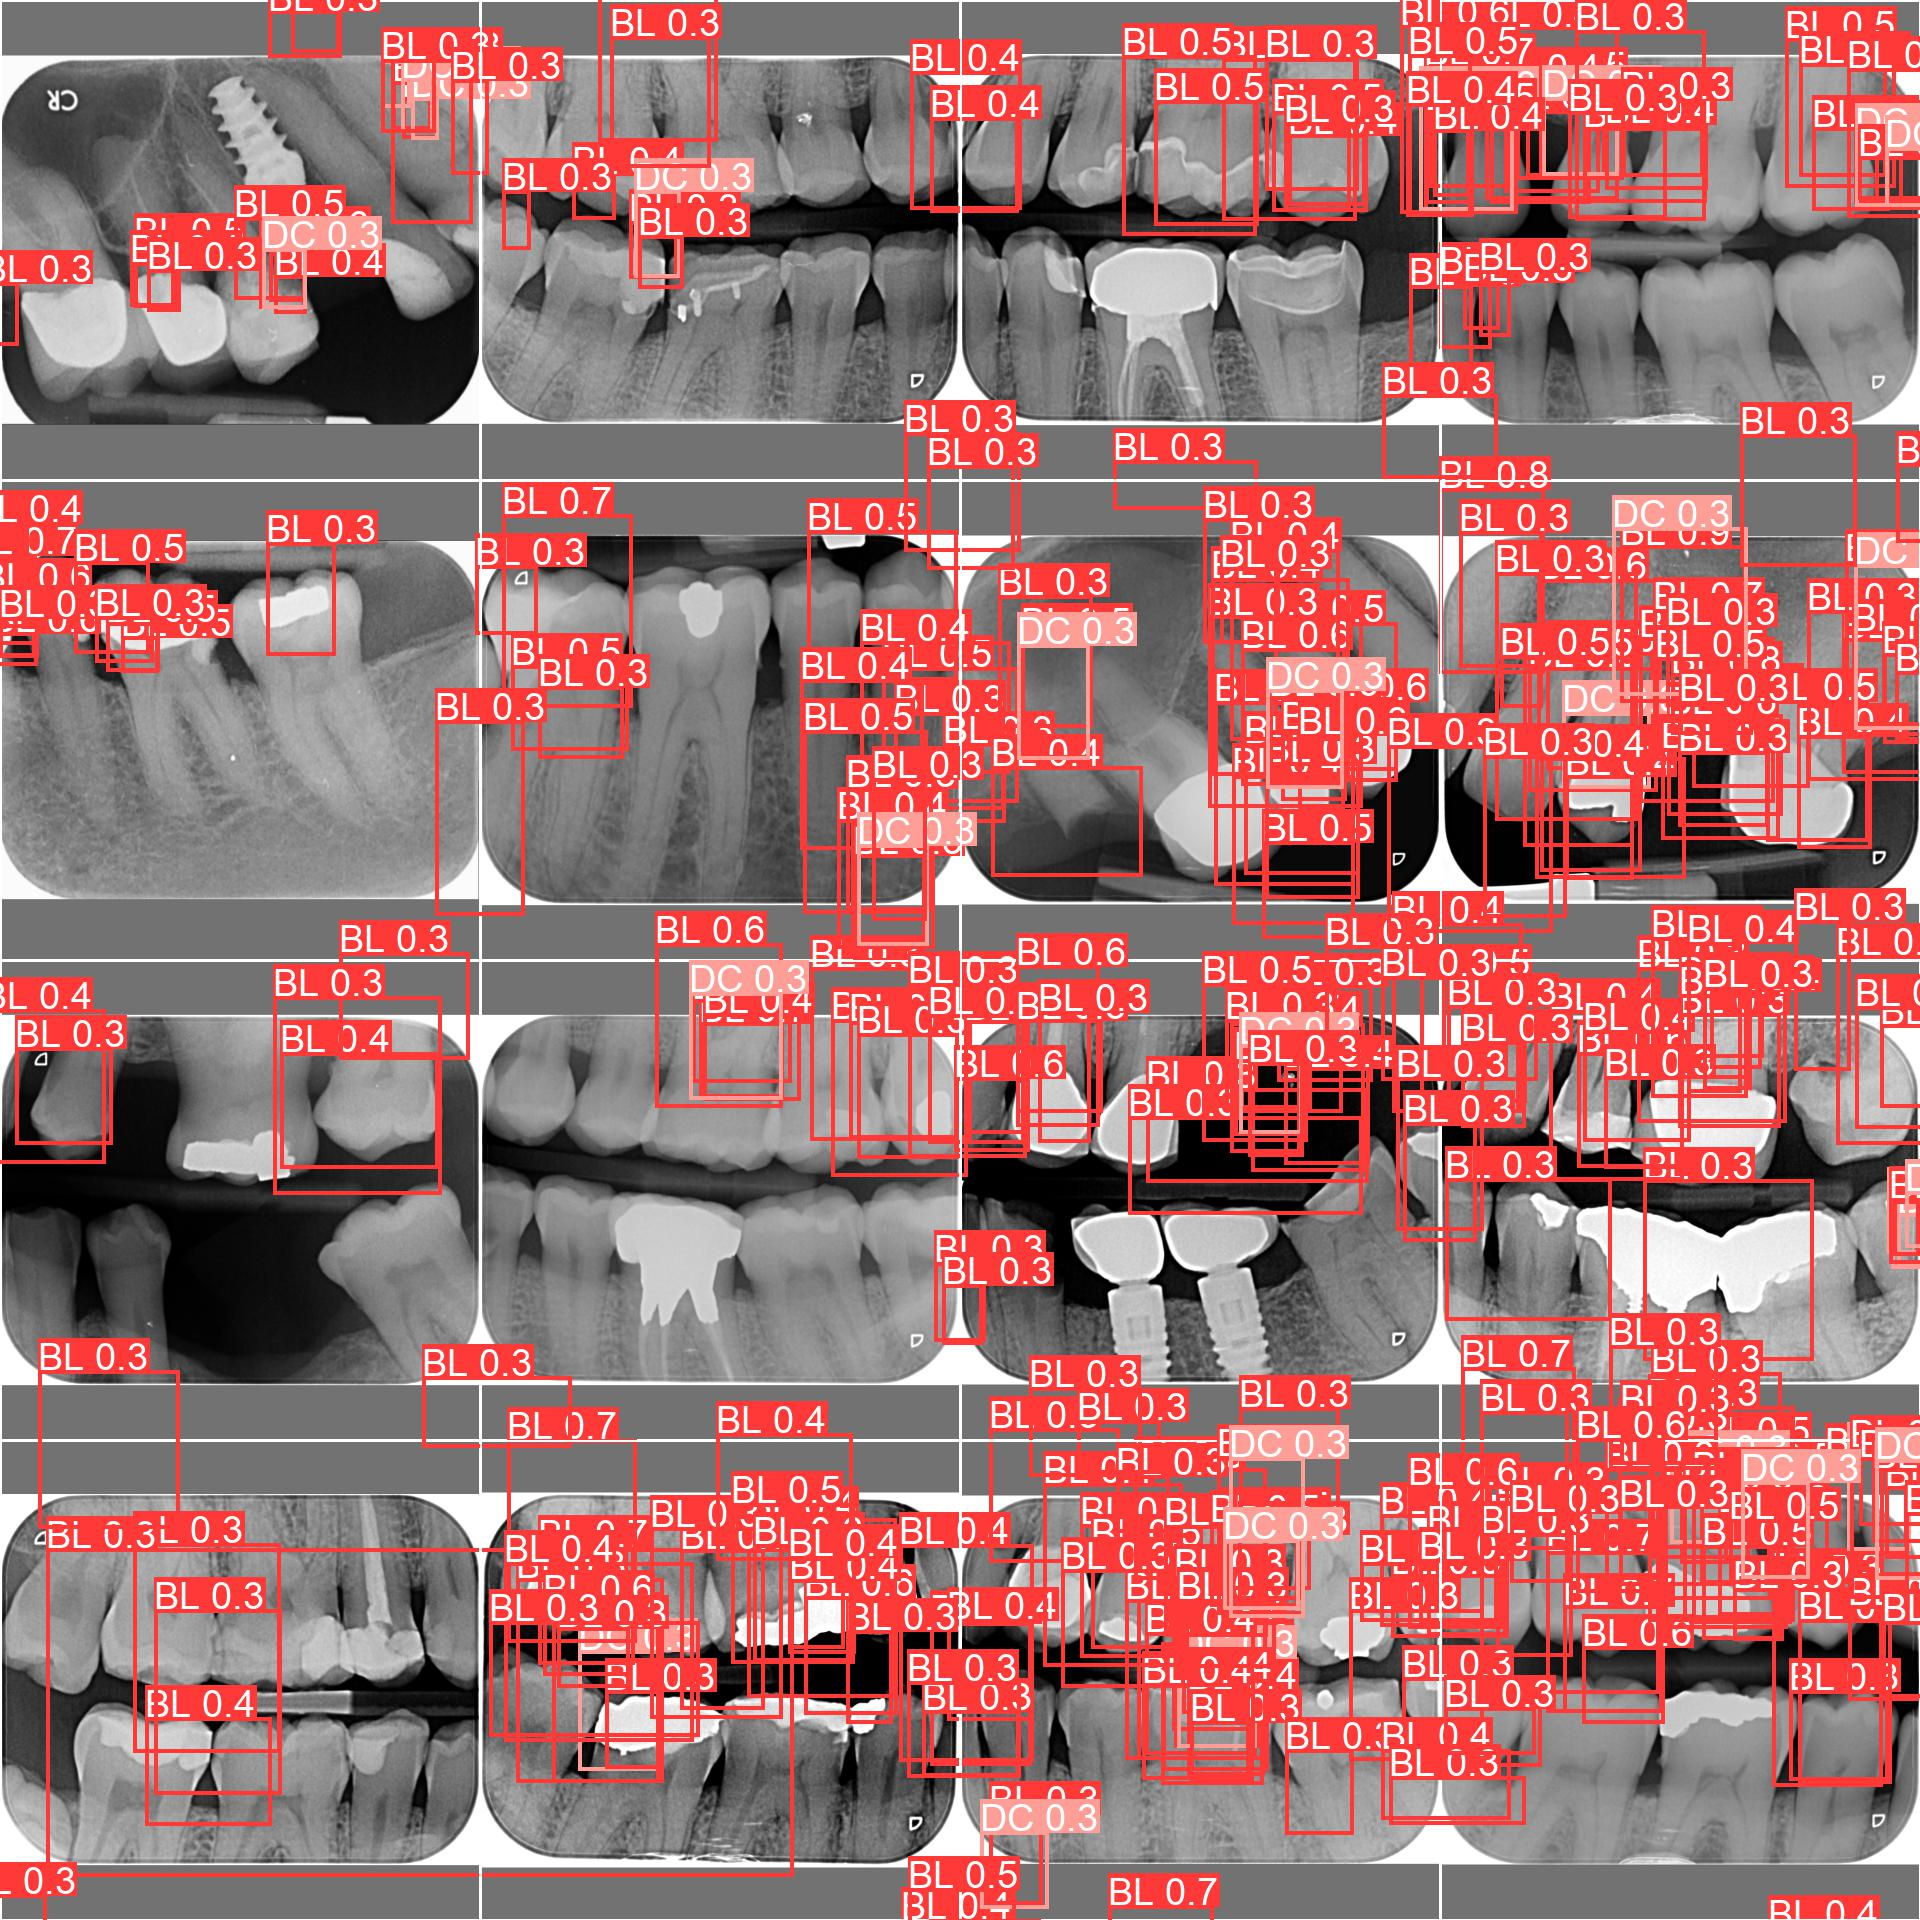

In [91]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

plot_images(imgs, img_info_map['yolo_labels'], names = ['BL', 'DC'])
pil_img = Image(filename='images.jpg')
display(pil_img)

## CYOLO labels (TODO: fix the boxes -- normalize)

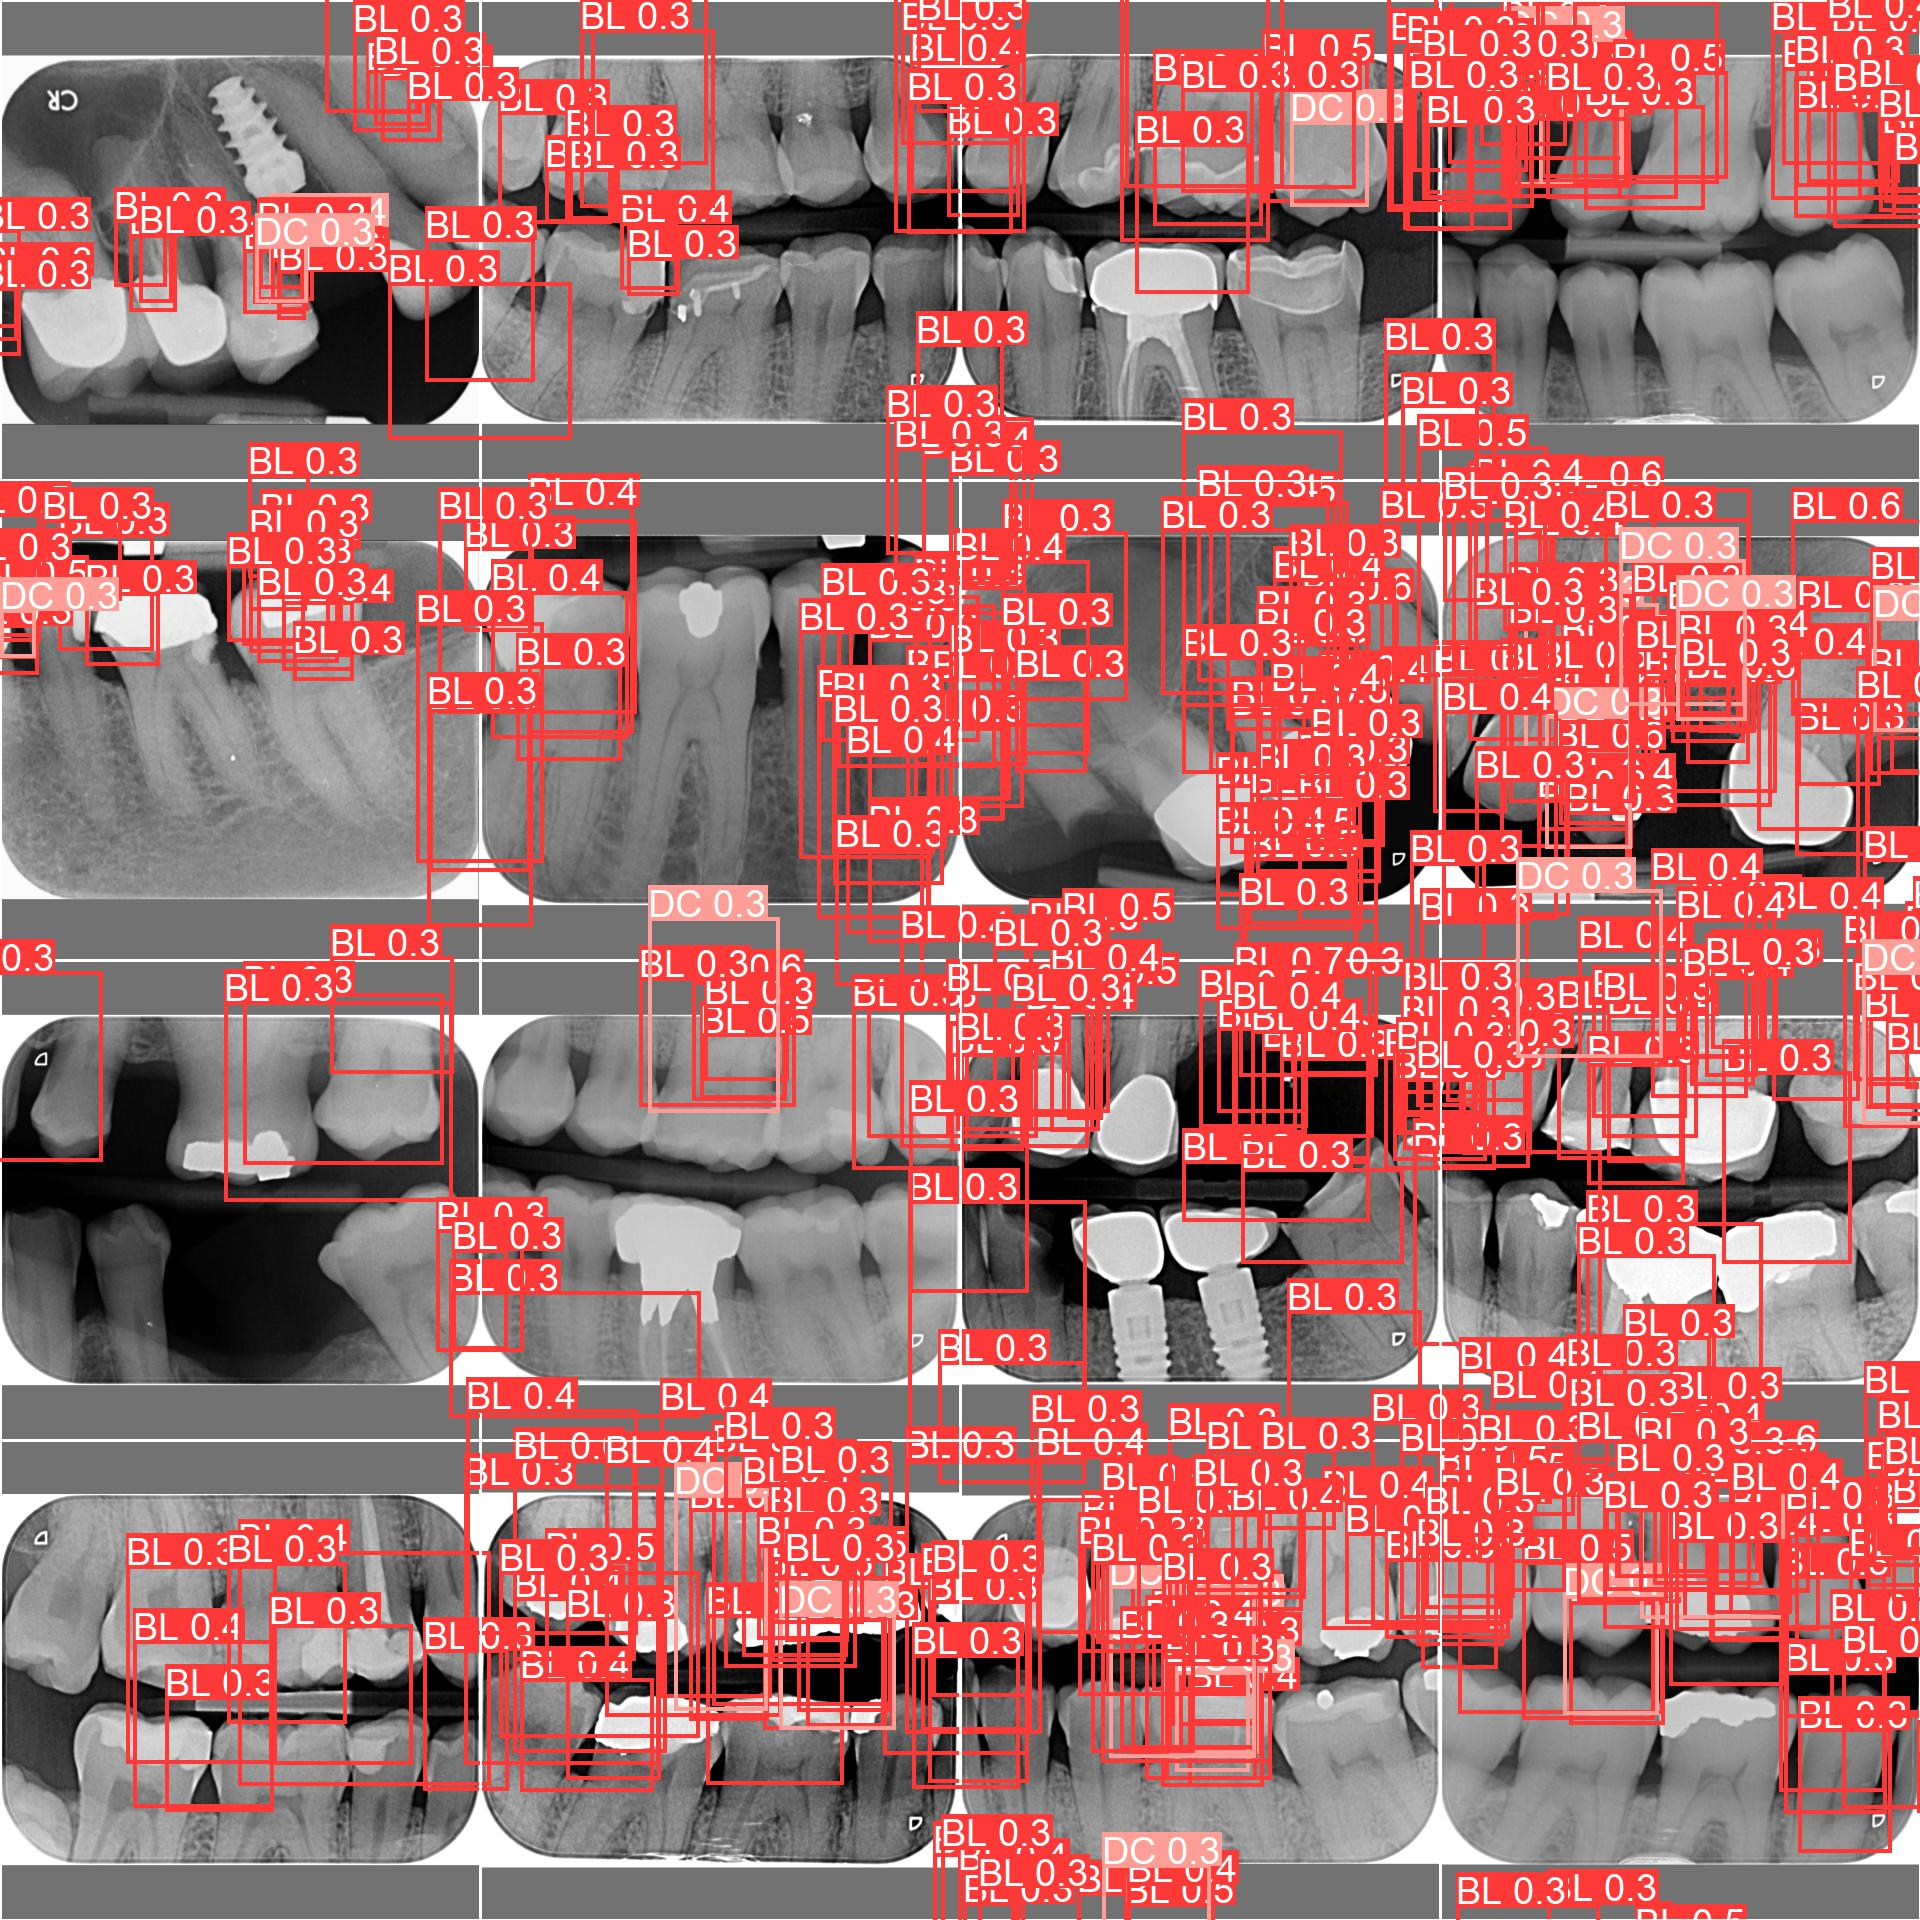

In [95]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

plot_images(imgs, img_info_map['cyolo_labels'], names = ['BL', 'DC'])
pil_img = Image(filename='images.jpg')
display(pil_img)

In [56]:
print(df_exp191.columns[0])

               epoch


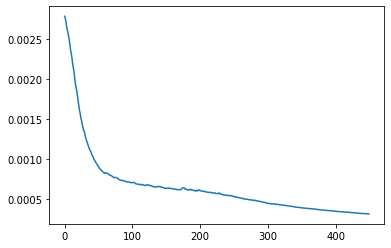

In [62]:
plt.plot(df_exp191[df_exp191.columns[0]], df_exp191[df_exp191.columns[3]])

<Figure size 36000x10800 with 0 Axes>

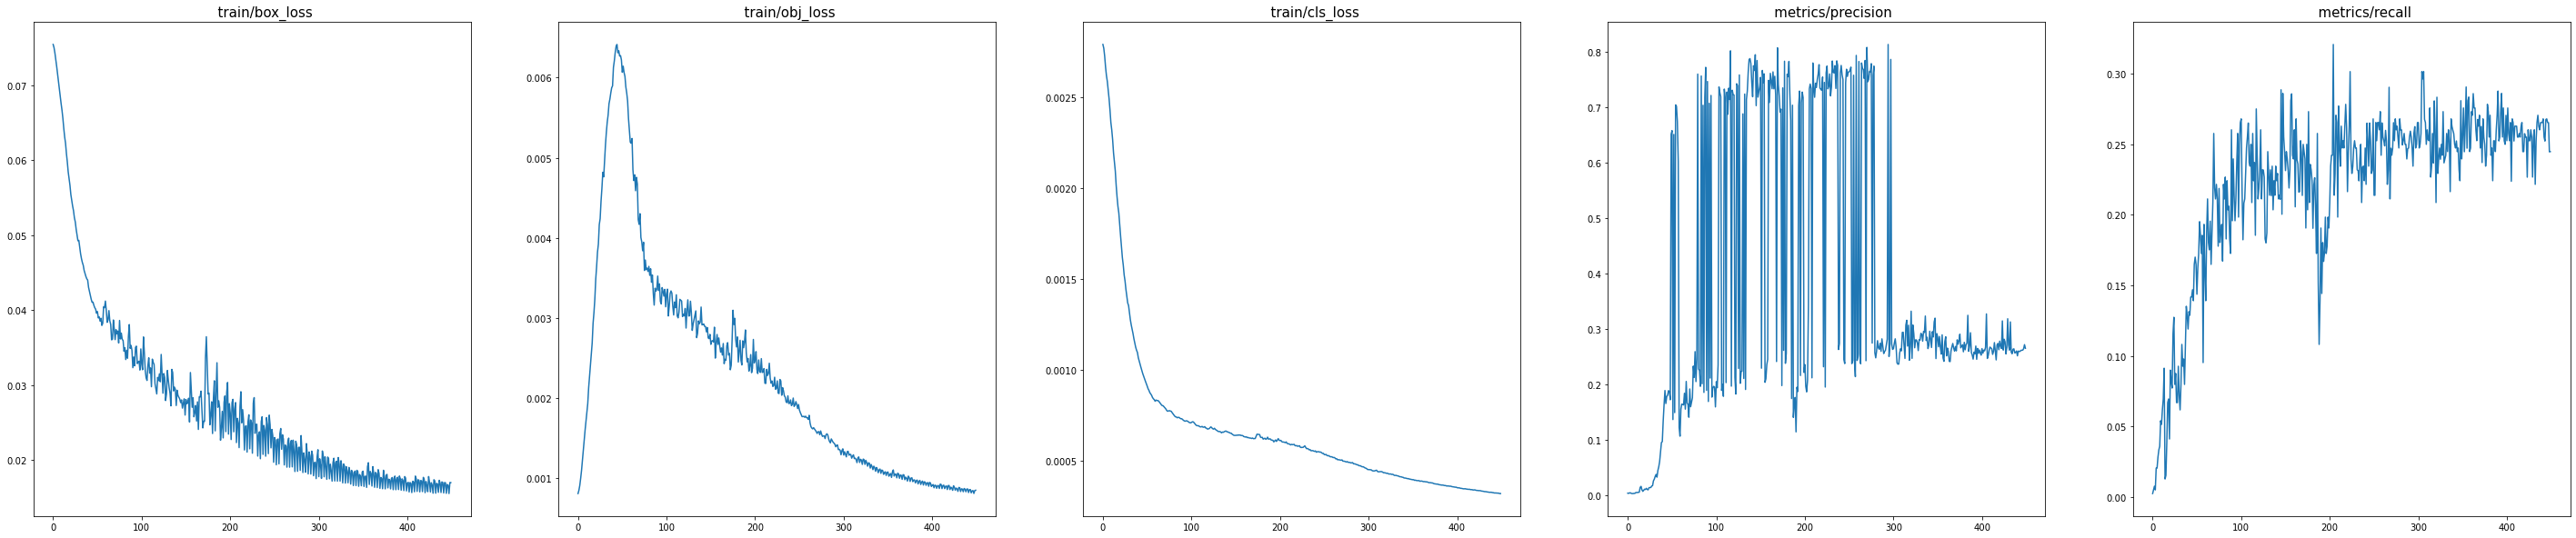

In [75]:
plt.figure(figsize=(500,150))
figure, axis = plt.subplots(1, 5, figsize = (50,10))
for i in range(5):
    axis[i].plot(df_exp191[df_exp191.columns[0]], df_exp191[df_exp191.columns[i+1]])
    axis[i].set_title(df_exp191.columns[i+1], fontsize = 15)
    


In [26]:
df_exp191.iloc[:,0]

0        0
1        1
2        2
3        3
4        4
      ... 
445    445
446    446
447    447
448    448
449    449
Name:                epoch, Length: 450, dtype: int64

In [ ]:
plt.figure(figsize=(600,600))

figure, axis = plt.subplots(2, 5, figsize = (20,10))

axis[0, 0].plot(df_exp102['               epoch'], df_exp102['      train/box_loss'], color='r', label='YOLO w/0 finetune')
axis[0, 0].plot(df_exp112['               epoch'], df_exp112['      train/box_loss'], color='g', label='YOLO w/ finetune')
axis[0, 0].set_title("train/box_loss", fontsize = 15)

plt.legend(bbox_to_anchor=(1.5, 1.5), loc='upper left')
figure.suptitle('YOLO baseline models comparsion', fontsize = 20)

plt.legend(prop={"size":12})
plt.show()